# Data Loading

In [1]:
# ATE Dataset
import json
f = open("ATE_train.json","r")
data_train = json.load(f)
f.close()

f = open("ATE_val.json","r")
data_val = json.load(f)
f.close()

f = open("ATE_test.json","r")
data_test = json.load(f)
f.close()
len(data_train)

906

In [15]:
# NER Dataset
import json
f = open("NER_train_rev1.json","r")
data_train = json.load(f)
f.close()

f = open("NER_val_rev1.json","r")
data_val = json.load(f)
f.close()

f = open("NER_test_rev1.json","r")
data_test = json.load(f)
f.close()
data_train

{'eb743c80dad844e199c05defeeffd849': {'text': 'PW.21 Pradeep was also shifted to Gandhi Hospital for better treatment.',
  'labels': ['O',
   'B_WITNESS',
   'O',
   'O',
   'O',
   'O',
   'B_ORG',
   'I_ORG',
   'O',
   'O',
   'O']},
 'ec8db09786124e7d845ef52a3bbf169b': {'text': 'The cause of action for filing the present suit arose on 21.10.1993 when the defendant No.1 informed that the account has been opened by him in the Oriental Bank of Commerce and that the cause of action further arose on several dates when the reminders were sent to defendant No.1 for handing over the bonus share certificates and the dividends to the Trust.',
  'labels': ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B_DATE',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B_ORG',
   'I_ORG',
   'I_ORG',
   'I_ORG',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   '

# Padding words and labels

In [2]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.preprocessing import LabelEncoder

def pad_and_encode_data(data:dict,maxlen:int,lenc:LabelEncoder=None):
    tokens = []
    labels = []
    isgiven = False
    if(lenc == None):
        l = LabelEncoder()
        isgiven = True
    else:
        l = lenc

    for i in data.keys():
        f= data[i]["text"].split(' ')
        g = data[i]["labels"]
        if (len(f) != len(g)):
            continue
        tokens.append(data[i]["text"].split(' '))
        labels.append(data[i]["labels"])
        if(len(tokens[-1]) != len(labels[-1])):
            print("some thing is wrong",print(len(tokens),len(labels)))
    
    tokens = pad_sequences(sequences=tokens,maxlen=maxlen,dtype=object,padding="post",truncating="post",value="<pad>")
    labels = pad_sequences(sequences=labels,maxlen=maxlen,dtype=object,padding="post",truncating="post",value="<pad>")
    labels2 = []
    if (isgiven):
        l.fit(np.unique(labels))
    for i in labels:
        labels2.append(l.transform(i))
    del labels
    
    return tokens, labels2, l

2024-03-13 12:57:06.554848: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-13 12:57:06.556089: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 12:57:06.617490: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 12:57:06.837926: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 12:57:07.774894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

# Embedder for each word embedding

In [3]:
import gensim
import re
import numpy as np

class Word2Vec:
    def __init__(self,path: str,pad: str):
        self.model = gensim.models.KeyedVectors.load(path)
        self.pad = pad

    def word2vec_preprocessing(self,token):
        j = token
        #UK to US conversion of some frequent characters
        g_change = {
            "offence" :"offense",
            "offences":"offenses",
            "favour"  :"favor",
            "defence" :"defense",
            "licence" :"license",
            "Honble"  :"Hon'ble"
        }
        #removing non compactible tokens and converting to suitable format
        for p  in '''(),[]<>/?!|=:;$\'%^_{}~%\"''':
            if len(j) == 1:
                j = '<pun>'
            else:
                j = j.replace(p,'')
            
        j = re.sub(r"\B\.\B",'',j)
        j = re.sub(r"\b\.\B",'',j)
        j = re.sub(r"[0-9]{4,}",'####',j)
        j = re.sub(r"[0-9]{3}" ,'###',j)
        j = re.sub(r"[0-9]{2}" ,'##',j)
        j = re.sub(r"[0-9]\."  ,'#.',j)
        if j in ['a','of','and','to']:
            j = '<red>'
        if j in g_change.keys():
            j = g_change[j]

        return j
    
    def encode(self,token: list):
        tokens = token
        vec = []
        for  i in range(len(tokens)):
            tokens[i] = self.word2vec_preprocessing(tokens[i])

        for i in range(len(tokens)):
            try:
                vec.append(self.model.get_vector(tokens[i]))
            except KeyError:
                if (tokens[i] == self.pad):
                    vec.append(np.full((300),-1.0))
                elif (tokens[i] == "<red>"):
                    vec.append(np.full( (300),1.0))
                elif (tokens[i] == "<pun>"):
                    vec.append(np.full((300),-0.5))
                else:
                    vec.append(np.zeros(300))
        
        if(len(vec) != len(token)):
            print("were doomed")
        return np.array(vec)

In [4]:
import gensim
import re
import numpy as np

class Glove:
    def __init__(self,path: str,pad: str):
        self.model = gensim.models.KeyedVectors.load(path)
        self.pad = pad

    def glove_preprocessing(self,token : str):
        j = token.casefold()
        for p  in '''/|=:;$%^_{}~%\'''':
            j = j.replace(p,'')
        j = re.sub(r"\B[\.\":;]\B",'',j)
        j = re.sub(r"\b[\.\":;]\B",'',j)
        j = re.sub(r"\B[\.\":;]\b",'',j)
        return j
    
    def encode(self,token: list):
        tokens = token
        vec = []
        for  i in range(len(tokens)):
            tokens[i] = self.glove_preprocessing(tokens[i])

        for i in range(len(tokens)):
            try:
                vec.append(self.model.get_vector(tokens[i]))
            except KeyError:
                if (tokens[i] == self.pad):
                    vec.append(np.full((300),-1.0))
                else:
                    vec.append(np.zeros(300))
        
        if(len(vec) != len(token)):
            print("were doomed")
        return np.array(vec)

In [5]:
import gensim
import re
import numpy as np

class Fasttext:
    def __init__(self,path: str,pad: str):
        self.model = gensim.models.KeyedVectors.load(path)
        self.pad = pad

    def fs_preprocessing(self,token : str):
        j = token
        for p  in '''/|=:;$%^_{}~%\'''':
            j = j.replace(p,'')
        j = re.sub(r"\B[\.\":;]\B",'',j)
        j = re.sub(r"\b[\.\":;]\B",'',j)
        j = re.sub(r"\B[\.\":;]\b",'',j)
        return j
    
    def encode(self,token: list):
        tokens = token
        vec = []
        for  i in range(len(tokens)):
            tokens[i] = self.fs_preprocessing(tokens[i])

        for i in range(len(tokens)):
            try:
                vec.append(self.model.get_vector(tokens[i]))
            except KeyError:
                if (tokens[i] == self.pad):
                    vec.append(np.full((300),-1.0))
                else:
                    vec.append(np.zeros(300))
        
        if(len(vec) != len(token)):
            print("were doomed")
        return np.array(vec)

# Data Generators

In [6]:
def data_generator(X,y, batch_size):
    texts  = X
    labels = y
    while True:
        for i in range(0, len(texts), batch_size):
            batch_texts  = texts[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            yield batch_texts, np.array(batch_labels)

In [7]:
def data_generatorx(X, batch_size):
    texts = X
    while True:
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            yield (batch_texts,)
            

# Model Params

In [9]:
MAX_LEN = 100

In [ ]:
import pickle
f = open("ENCODING_NER.pkl","rb")
label_encoder = pickle.load(f)
f.close()

In [ ]:
import pickle
f = open("ENCODING_ATE.pkl","rb")
label_encoder = pickle.load(f)
f.close()

In [16]:
train_x, train_y, _ = pad_and_encode_data(data_train,MAX_LEN,label_encoder)
val_x, val_y, _ = pad_and_encode_data(data_val,MAX_LEN,label_encoder)
text_x, text_y, _ = pad_and_encode_data(data_test,MAX_LEN,label_encoder)

Note: Delete embedding after use to save memory

In [39]:
embedding = Word2Vec("models/word2vec-google-news-300.model","<pad>")

In [9]:
embedding = Glove("models/glove-wiki-gigaword-300.model","<pad>")

In [65]:
embedding = Fasttext("models/fasttext-wiki-news-subwords-300.model","<pad>")

In [10]:
train_x_vec = np.array([embedding.encode(i) for i in train_x])
val_x_vec = np.array([embedding.encode(i) for i in val_x])
test_x_vec = np.array([embedding.encode(i) for i in text_x])

In [23]:
from keras.callbacks import Callback
from sklearn.metrics import f1_score

class F1ScoreCallbackTrain(Callback):
    def __init__(self,X_train,y_train,X_val,y_val):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.val_max = 0
        self.label_to_index = {}

    def on_epoch_end(self, epoch, logs=None):
        train_predict = np.argmax(self.model.predict(data_generatorx(self.X_train,32),steps=int(np.ceil(len(self.X_train) / 32)),verbose=0), axis=2)
        val_predict = np.argmax(self.model.predict(data_generatorx(self.X_val,32),steps=int(np.ceil(len(self.X_val) / 32)),verbose=0), axis=2)

        train_f1 = f1_score(np.array(self.y_train).flatten(), train_predict.flatten(), average='macro')
        val_f1   = f1_score(np.array(self.y_val).flatten(), val_predict.flatten(), average='macro')

        logs['train_f1_score'] = train_f1
        logs['val_f1_score'] = val_f1
        if(val_f1 > self.val_max):
            val_max = val_f1
            self.model.save(MODEL_SAVE_LOC)
        
        print(f"Epoch {epoch + 1} - Train F1 Score: {train_f1:.4f}, Validation F1 Score: {val_f1:.4f}")
         

In [11]:
del embedding

In [29]:
import matplotlib.pyplot as plt
def plot_metrics(history, task, model_type):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss {task} Dataset for {model_type}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['train_f1_score'], label='Training F1 Score')
    plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
    plt.title(f'Model F1 Score {task} Dataset for {model_type}')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Model Training

## RNN

In [21]:
MODEL_SAVE_LOC = "gl_RNN.keras"
from keras.layers import SimpleRNN, Dense
from keras.models import Sequential

model = Sequential([
    SimpleRNN(300,return_sequences=True),
    Dense(len(label_encoder.classes_),activation="softmax")
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
f1_callback = F1ScoreCallbackTrain(train_x_vec, train_y, val_x_vec, val_y)
history = model.fit(data_generator(train_x_vec,train_y,32),
                        steps_per_epoch=len(train_x_vec) // 32,
                        epochs=20,
                        validation_data=data_generator(val_x_vec,val_y,32),
                        validation_steps=len(val_x_vec) // 32,
                        callbacks=[f1_callback],verbose=0)
plot_metrics(history, 'NER-fs', 'RNN')


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Epoch 1 - Train F1 Score: 0.2159, Validation F1 Score: 0.2130
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Epoch 2 - Train F1 Score: 0.2993, Validation F1 Score: 0.2964
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Epoch 3 - Train F1 Score: 0.3274, Validation F1 Score: 0.3214
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Epoch 4 - Train F1 Score: 0.3436, Validation F1 Score: 0.3398
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Epoch 5 - Train F1 Score: 0.3646, Validation F1 Score: 0.3588
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Epoch 6 - Train F1 Score: 0.4027, Validation F1 Score: 0.4026
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Epoch 7 - Train F1 Score: 0.3962, Validation F1 Score: 0.3952
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Epoch 8 - Train F1 Score: 0.4108, Validation F1 Score: 0.4110
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Epoch 9 - Train F1 Score: 0.4540, Validation F1 Score: 0.4490
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Epoch 10 - Train F1 Score: 0.4745, Validat

NameError: name 'plot_metrics' is not defined

In [18]:
model.save("fs_RNN.keras")

## LSTM

In [30]:
from keras.layers import LSTM, Dense
from keras.models import Sequential
MODEL_SAVE_LOC = "gl_LSTM.keras"
model = Sequential([
    LSTM(300,return_sequences=True),
    Dense(len(label_encoder.classes_),activation="softmax")
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
f1_callback = F1ScoreCallbackTrain(train_x_vec, train_y, val_x_vec, val_y)
history = model.fit(data_generator(train_x_vec,train_y,32),
                        steps_per_epoch=len(train_x_vec) // 32,
                        epochs=20,
                        validation_data=data_generator(val_x_vec,val_y,32),
                        validation_steps=len(val_x_vec) // 32,
                        callbacks=[f1_callback])
plot_metrics(history, 'NER-fs', 'LSTM')
model.save("fs_LSTM.keras")

Epoch 1/20


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/stepe
Epoch 1 - Train F1 Score: 0.1104, Validation F1 Score: 0.1073
213/213 ━━━━━━━━━━━━━━━━━━━━ 33s 152ms/step - accuracy: 0.8945 - loss: 0.5231 - val_accuracy: 0.9041 - val_loss: 0.4214 - train_f1_score: 0.1104 - val_f1_score: 0.1073
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/stepe
Epoch 2 - Train F1 Score: 0.2317, Validation F1 Score: 0.2291
213/213 ━━━━━━━━━━━━━━━━━━━━ 33s 157ms/step - accuracy: 0.9410 - loss: 0.2308 - val_accuracy: 0.9153 - val_loss: 0.3501 - train_f1_score: 0.2317 - val_f1_score: 0.2291
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/stepe
Epoch 3 - Train F1 Score: 0.2947, Validation F1 Score: 0.2924
213/213 ━━━━━━━━━━━━━━━━━━━━ 33s 157ms/step - accuracy: 0.9513 - loss: 0.1782 - val_accuracy: 0.9226 - val_loss: 0.2976 - train_f1_score: 0.2947 - val_f1_score: 0.2924
Epoch 4/20
201/213 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9562 - loss: 0.1556

## GRU

In [76]:
from keras.layers import GRU, Dense
from keras.models import Sequential
MODEL_SAVE_LOC = "fs_GRU-ATE.keras"
model = Sequential([
    GRU(300,return_sequences=True),
    Dense(len(label_encoder.classes_),activation="softmax")
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Epoch 1/20


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/stepep - accuracy: 0.7316 - loss: 0.
Epoch 1 - Train F1 Score: 0.4655, Validation F1 Score: 0.4663
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.7362 - loss: 0.5436 - val_accuracy: 0.9547 - val_loss: 0.1346 - train_f1_score: 0.4655 - val_f1_score: 0.4663
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/stepep - accuracy: 0.9597 - loss: 0.
Epoch 2 - Train F1 Score: 0.4724, Validation F1 Score: 0.4730
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9598 - loss: 0.1307 - val_accuracy: 0.9633 - val_loss: 0.1130 - train_f1_score: 0.4724 - val_f1_score: 0.4730
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/stepep - accuracy: 0.9627 - loss: 0.
Epoch 3 - Train F1 Score: 0.4771, Validation F1 Score: 0.4806
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9627 - loss: 0.1118 - val_accuracy: 0.9627 - val_loss: 0.1043 - train_f1_score: 0.4771 - val_f1_score: 0.4806
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/stepep - accuracy: 0.9622 - loss: 0.
Epoch 

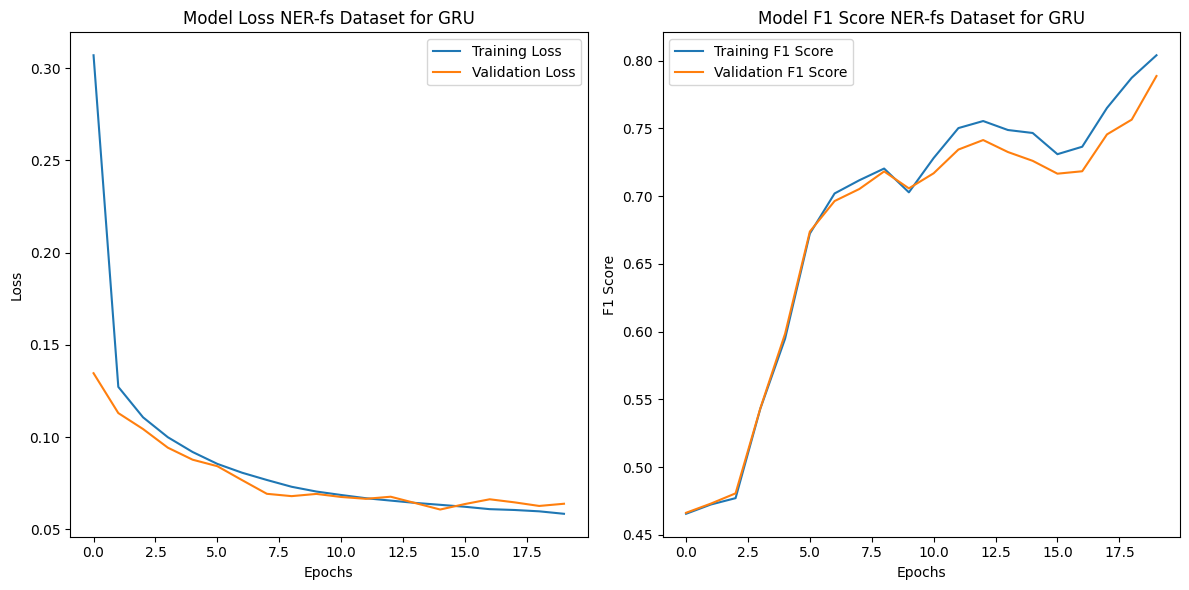

In [77]:
f1_callback = F1ScoreCallbackTrain(train_x_vec, train_y, val_x_vec, val_y)
history = model.fit(data_generator(train_x_vec,train_y,32),
                        steps_per_epoch=len(train_x_vec) // 32,
                        epochs=20,
                        validation_data=data_generator(val_x_vec,val_y,32),
                        validation_steps=len(val_x_vec) // 32,
                        callbacks=[f1_callback])
plot_metrics(history, 'NER-fs', 'GRU')

# TEST SCRIPT

In [14]:
from sklearn.metrics import accuracy_score, f1_score
def print_stats(model,title,full=False):
    # test_predict = model.predict(data_generatorx(test_x_vec,32),steps=int(np.ceil(len(test_x_vec) / 32)),verbose=0)[0]
    test_predict = np.argmax(model.predict(data_generatorx(test_x_vec,32),steps=int(np.ceil(len(test_x_vec) / 32)),verbose=0), axis=2)
    test_f1 = f1_score(np.array(text_y).flatten(), test_predict.flatten(), average=None)
    test_acc = accuracy_score(np.array(text_y).flatten(), test_predict.flatten())
    lb = label_encoder.inverse_transform(np.argsort(test_f1))
    test_f1 = np.sort(test_f1)
    print("--------------------------------------------------------------------------------")
    print(f"Overal Test Results for {title}: Accuracy: {test_acc*100:.2f} % F1: {np.mean(test_f1[:-1]):.4f}")
    print("--------------------------------------------------------------------------------")
    if(full):
        for i in range(len(test_f1)):
            print("F1_macro for",lb[i],' '*(15-len(lb[i])),':',f"{test_f1[i]:.4f}")

In [28]:
from keras.saving import load_model
m = load_model("gl_RNN.keras")
print_stats(m,"gl RNN NER")


--------------------------------------------------------------------------------
Overal Test Results for gl RNN NER: Accuracy: 95.02 % F1: 0.3987
--------------------------------------------------------------------------------
